Generate Data

In [ ]:
!pip install pymc3

In [59]:
from warnings import filterwarnings
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
from pymc3.variational.callbacks import CheckParametersConvergence
import pymc3 as pm
import seaborn as sns
import theano
import theano.tensor as T
from tensorflow import keras
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer, load_digits
from sklearn.preprocessing import scale
import tensorflow as tf
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
%config InlineBackend.figure_format = 'retina'
floatX = theano.config.floatX
filterwarnings("ignore")
sns.set_style("white")
sns.set_palette("muted")

### **Binary Classification**

**Import binary dataset and split it into train and test set**

In [82]:
bin_dataset = load_breast_cancer()
X = bin_dataset.data
Y = bin_dataset.target

X = scale(X)            #scale the training data
X = X.astype(floatX)    #cast panda objects to float64
Y = Y.astype(floatX)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2) #split the data into 80% train and 20%test
print("Train set shape:",X_train.shape)
print("Test set shape:",X_test.shape)

Train set shape: (455, 30)
Test set shape: (114, 30)


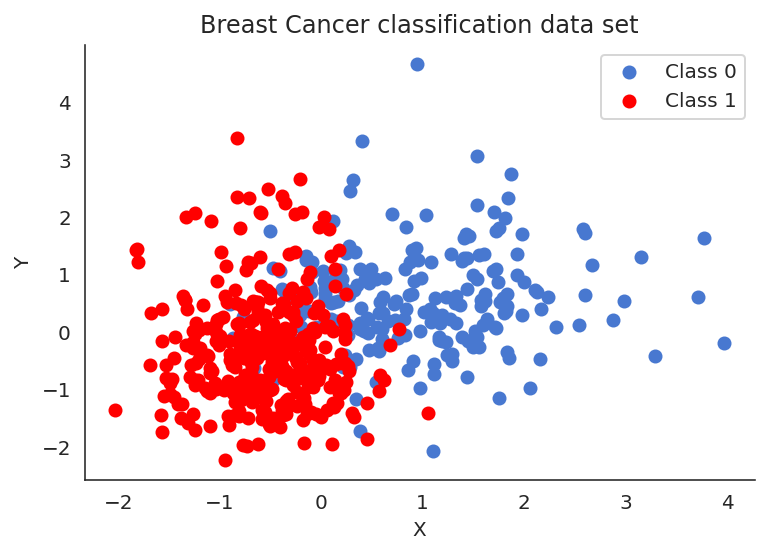

In [18]:
fig, ax = plt.subplots()
ax.scatter(X[Y == 0, 0], X[Y == 0, 1], label="Class 0")
ax.scatter(X[Y == 1, 0], X[Y == 1, 1], color="r", label="Class 1")
sns.despine()
ax.legend()
ax.set(xlabel="X", ylabel="Y", title="Breast Cancer classification data set");

**BNN Model Specification**

(30, 5)
(5, 5)
(5, 2)


Finished [100%]: Average Loss = 10.208


No handles with labels found to put in legend.


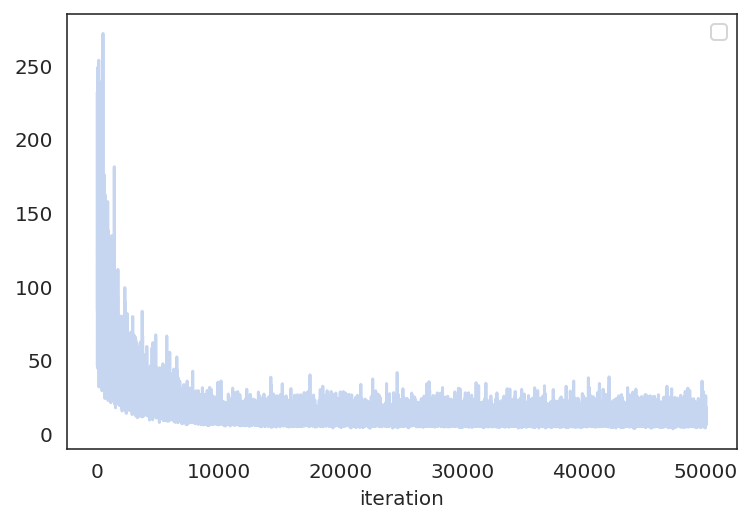

In [95]:
n_hidden=5

# Initialize random weights between each layer
#Weights priors 
init_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_1_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_bias_1 = np.random.randn(n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden, 2).astype(floatX)
init_bias_out = np.random.randn(2).astype(floatX)
print(init_1.shape)
print(init_1_2.shape)
print(init_out.shape)
with pm.Model() as neural_network:

    #turn inputs and outputs into shared variables using the data container pm.Data
    ann_input = pm.Data("ann_input", X_train)
    ann_output = pm.Data("ann_output", Y_train)

    #Create posterior distributions for every weight
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(
        X_train.shape[1], n_hidden), testval=init_1)
    bias_in_1 = pm.Normal("b_in_1", 0, sigma=1, shape=(
        n_hidden), testval=init_bias_1)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal(
        "w_2_out", 0, sigma=1, shape=(n_hidden, 2), testval=init_out)
    bias_2_out = pm.Normal("b_2_out", 0, sigma=1,
                           shape=(2), testval=init_bias_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.sigmoid(pm.math.dot(
        ann_input, weights_in_1) + bias_in_1)
    act_out = T.nnet.softmax(pm.math.dot(
        act_1, weights_2_out) + bias_2_out)
    out = pm.Categorical(
        "out", p=act_out, observed=ann_output.T, total_size=X_train.shape[0])

    inference = pm.ADVI()
    X_batch = pm.Minibatch(X_train, batch_size=50)
    Y_batch = pm.Minibatch(Y_train, batch_size=50)
    approx = pm.fit(n=50000, method=inference,
                    callbacks=[CheckParametersConvergence()],
                    more_replacements={ann_input: X_batch, ann_output: Y_batch})
    trace_advi = approx.sample(5000)

    #swap out training data for test data
    pm.set_data(new_data={"ann_input": X_test,
                          "ann_output": Y_test}, model=neural_network)
    #run test data through data model
    ppc = pm.sample_posterior_predictive(
        trace_advi, samples=1000, progressbar=True, model=neural_network
    )

    plt.plot(inference.hist, alpha=0.3)
    plt.legend()
    plt.xlabel("iteration");



Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


<Figure size 1440x1280 with 0 Axes>

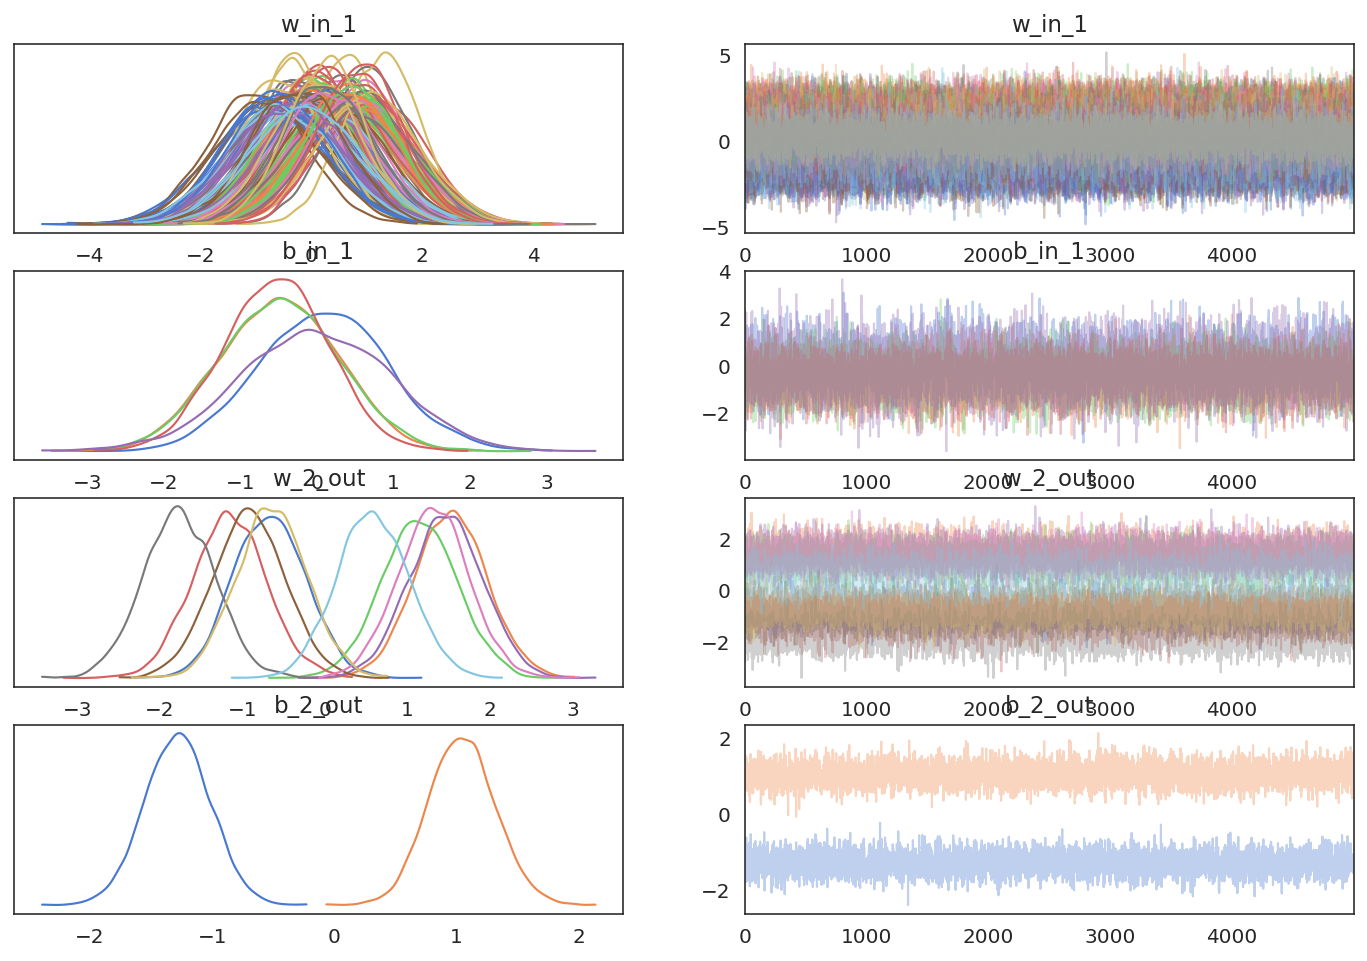

In [101]:
trace = approx.sample(draws=5000)
az.plot_trace(trace);

**Classical ANN**

In [83]:
from keras.layers import Dense, Dropout
def baseline_model_bnn():
  model_bnn = tf.keras.models.Sequential()
  model_bnn.add(Dense(5, input_dim=X_train.shape[1], activation='relu'))
  model_bnn.add(Dense(2, activation='softmax'))

  model_bnn.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model_bnn

In [84]:
estimator = KerasClassifier(build_fn=baseline_model_bnn, epochs=200, batch_size=50, verbose=0)

In [85]:
kfold = KFold(n_splits=10, shuffle=True)

**Results**

In [93]:
y_pred_bnn = mode(ppc["out"]).mode[0,:]

print("Test set accuracy for BNN: %.2f%%" % (100*accuracy_score(Y_test, y_pred_bnn)))
print("Test set accuracy for ANN: %.2f%%"% (results.mean()*100))

Test set accuracy for BNN: 98.25%
Test set accuracy for ANN: 97.35%


### **Multiclass Classification**

In [30]:
dig_dataset = load_digits()
X = dig_dataset.data
Y = dig_dataset.target

X = scale(X)            #scale the training data
X = X.astype(floatX)    #cast panda objects to float64
Y = Y.astype(floatX)


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2) #split the data into 80% train and 20%test
print("Train set shape:",X_train.shape)
print("Test set shape:",X_test.shape)

Train set shape: (1437, 64)
Test set shape: (360, 64)


**BNN**

(30, 20)
(20, 20)
(20, 10)


Finished [100%]: Average Loss = 15.271


No handles with labels found to put in legend.


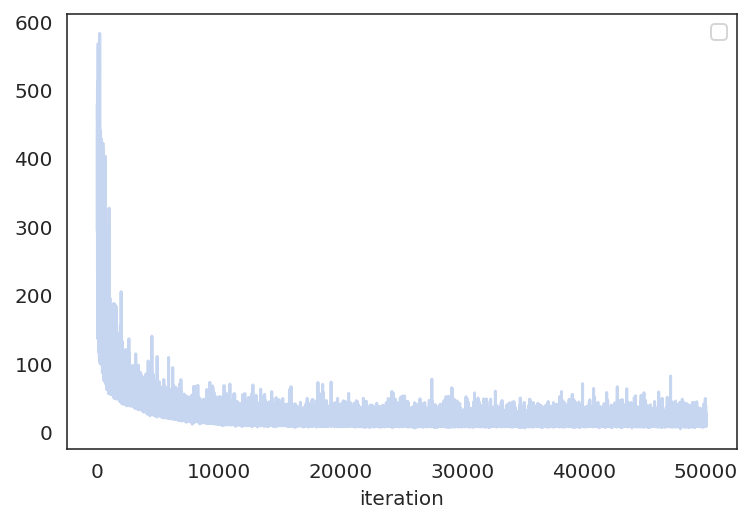

In [102]:
n_hidden=20

# Initialize random weights between each layer
#Weights priors 
init_1 = np.random.randn(X_train.shape[1], n_hidden).astype(floatX)
init_1_2 = np.random.randn(n_hidden, n_hidden).astype(floatX)
init_bias_1 = np.random.randn(n_hidden).astype(floatX)
init_out = np.random.randn(n_hidden, 10).astype(floatX)
init_bias_out = np.random.randn(10).astype(floatX)
print(init_1.shape)
print(init_1_2.shape)
print(init_out.shape)
with pm.Model() as neural_network:

    #turn inputs and outputs into shared variables using the data container pm.Data
    ann_input = pm.Data("ann_input", X_train)
    ann_output = pm.Data("ann_output", Y_train)

    #Create posterior distributions for every weight
    # Weights from input to hidden layer
    weights_in_1 = pm.Normal("w_in_1", 0, sigma=1, shape=(
        X_train.shape[1], n_hidden), testval=init_1)
    bias_in_1 = pm.Normal("b_in_1", 0, sigma=1, shape=(
        n_hidden), testval=init_bias_1)

    # Weights from hidden layer to output
    weights_2_out = pm.Normal(
        "w_2_out", 0, sigma=1, shape=(n_hidden, 10), testval=init_out)
    bias_2_out = pm.Normal("b_2_out", 0, sigma=1,
                           shape=(10), testval=init_bias_out)

    # Build neural-network using tanh activation function
    act_1 = pm.math.sigmoid(pm.math.dot(
        ann_input, weights_in_1) + bias_in_1)
    act_out = T.nnet.softmax(pm.math.dot(
        act_1, weights_2_out) + bias_2_out)
    out = pm.Categorical(
        "out", p=act_out, observed=ann_output.T, total_size=X_train.shape[0])

    inference = pm.ADVI()
    X_batch = pm.Minibatch(X_train, batch_size=50)
    Y_batch = pm.Minibatch(Y_train, batch_size=50)
    approx = pm.fit(n=50000, method=inference,
                    callbacks=[CheckParametersConvergence()],
                    more_replacements={ann_input: X_batch, ann_output: Y_batch})
    trace_advi = approx.sample(5000)

    #swap out training data for test data
    pm.set_data(new_data={"ann_input": X_test,
                          "ann_output": Y_test}, model=neural_network)
    #run test data through data model
    ppc = pm.sample_posterior_predictive(
        trace_advi, samples=1000, progressbar=True, model=neural_network
    )

    plt.plot(inference.hist, alpha=0.3)
    plt.legend()
    plt.xlabel("iteration");

Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


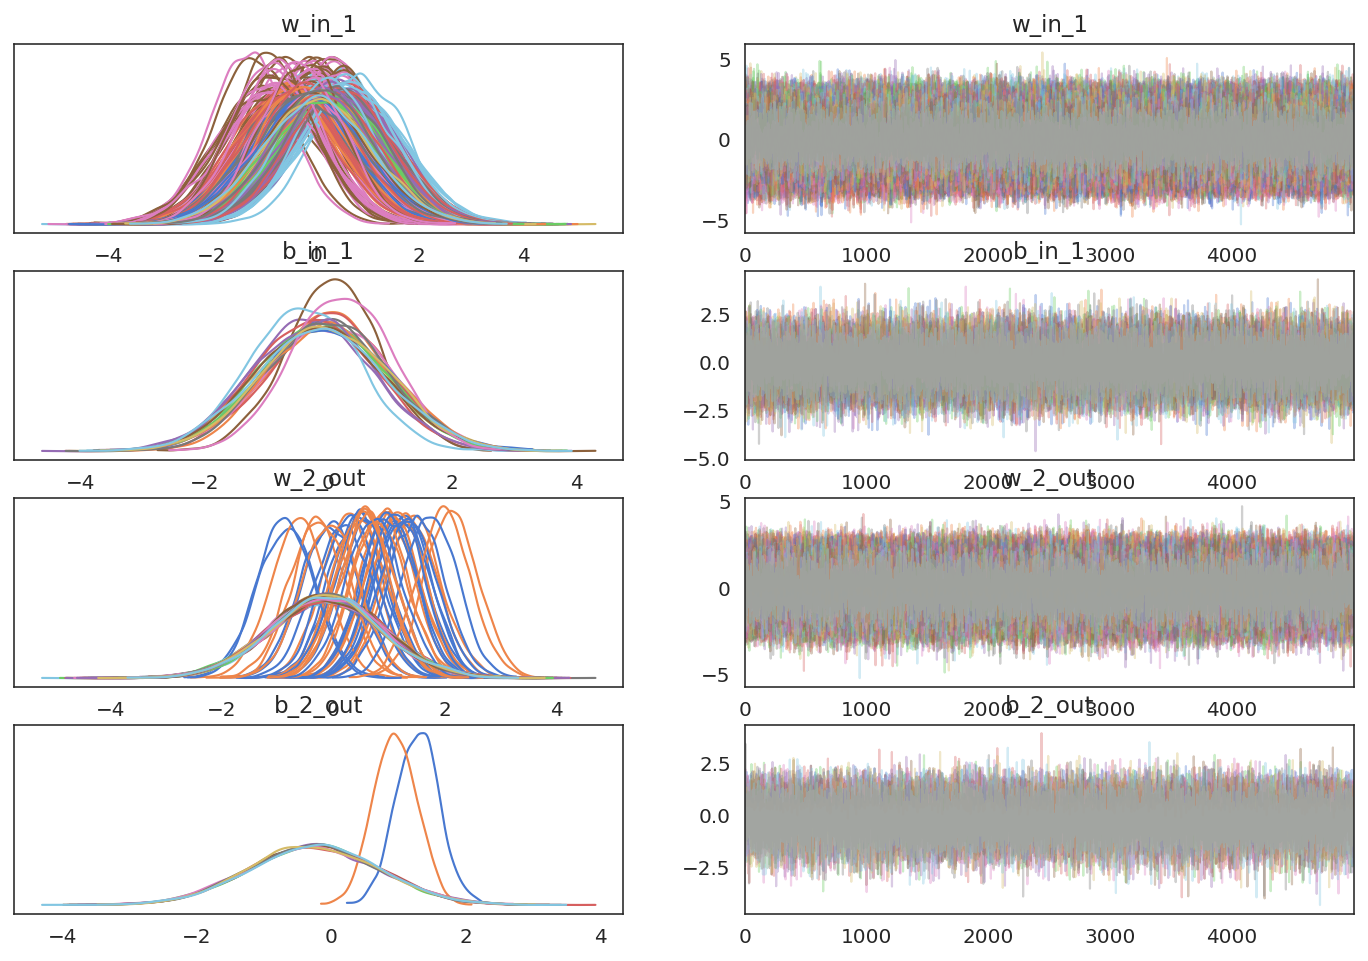

In [103]:
trace = approx.sample(draws=5000)

az.plot_trace(trace);

**Classical ANN**

In [56]:
from keras.layers import Dense, Dropout
def baseline_model():
  model = tf.keras.models.Sequential()
  model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
  model.add(Dense(10, activation='softmax'))
  # Compile model
  model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

  return model

In [57]:
estimator = KerasClassifier(build_fn=baseline_model, epochs=200, batch_size=50, verbose=0)

In [88]:
kfold = KFold(n_splits=10, shuffle=True)

results = cross_val_score(estimator, X_train, Y_train, cv=kfold)

**Results**

In [73]:
y_pred_bnn = mode(ppc["out"]).mode[0,:]

print("Test set accuracy for BNN: %.2f%%" % (100*accuracy_score(Y_test, y_pred_bnn)))
print("Test set accuracy for ANN: %.2f%%"% (results.mean()*100))
#print(f"Test set accuracy for an ANN: {100*accuracy_score(Y_test, y_pred_ann)}%")

Test set accuracy for BNN: 96.67%
Test set accuracy for ANN: 96.94%
